# Modulation Classification

## Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize 
from scipy.integrate import cumtrapz
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
import keras.models as models
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D
import json
from keras.optimizers import Adam
from scipy import integrate


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH = "/content/drive/MyDrive/Pattern Recognition/Modulation Classification"

## Dowload Dataset

In [6]:
%cp -av "/content/drive/MyDrive/Pattern Recognition/Modulation Classification/RML2016.10b.tar.bz2" "/content/dataset"

'/content/drive/MyDrive/Pattern Recognition/Modulation Classification/RML2016.10b.tar.bz2' -> '/content/dataset/RML2016.10b.tar.bz2'


In [7]:
!tar xjvf "/content/dataset/RML2016.10b.tar.bz2"

RML2016.10b.dat
LICENSE.TXT


In [ ]:
with open("/content/RML2016.10b.dat", 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()

In [8]:
file = open("/content/RML2016.10b.dat",'rb')
Xd = pickle.load(file, encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

## Visualization

In [ ]:
def randomVisualization():
  mod = lbl[0][0]
  idx = []
  res = []
  idx.append([0, mod.decode("utf-8"), lbl[0][1]])
  for i in range(len(lbl)):
    if lbl[i][0] == mod:
      continue
    idx.append([i-1, mod.decode("utf-8"), lbl[i-1][1]])
    mod = lbl[i][0]
    idx.append([i, mod.decode("utf-8"), lbl[i][1]])
  idx.append([i-1, lbl[i-1][0].decode("utf-8"), lbl[i-1][1]])
  return idx

In [ ]:
def plotFigures(idx):
  i = 0
  while i < len(idx):
    # plt.figure()
    # plt.title(str(id[1]) + " SNR = " + str(id[2]))
    # plt.plot(X[id[0]][0])
    # plt.plot(X[id[0]][1])

    fig, axs = plt.subplots(1,2, figsize=(20,5))
    axs[0].plot(X[idx[i][0]][0])
    axs[0].plot(X[idx[i][0]][1])
    axs[0].set_title(str(idx[i][1]) + ", SNR = " + str(idx[i][2]))
    axs[1].plot(X[idx[i+1][0]][0])
    axs[1].plot(X[idx[i+1][0]][1])
    axs[1].set_title(str(idx[i+1][1]) + ", SNR = " + str(idx[i+1][2]))
    i += 2


In [ ]:
X.shape

(1200000, 2, 128)

In [ ]:
idx = randomVisualization()
plotFigures(idx)

## Create Features

1. Raw time series as given (two channels)
2. First derivative in time (two channels)
3. Integral in time (two channels)
4. combinations of 1,2 and 3. (More channels)

In [ ]:
features = {}

In [ ]:
features['raw']        = X[:,0], X[:,1]

In [ ]:
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))

In [ ]:
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))

In [ ]:
features['raw'][1].shape

(1200000, 128)

In [ ]:
X = np.vstack(X)
X = np.asarray(X)
X = np.reshape(X, (1200000,256))

scaler = StandardScaler()
X = scaler.fit_transform(X)
lbl = np.asarray(lbl) 


In [ ]:
X_deriv = []
for x in X:
  X_deriv.append(np.gradient(x))

X_int = []
for x in X:
  X_int.append(cumtrapz(x, initial=0))

# X_combined = []
# for x,x_d,x_i in zip(X,X_deriv,X_int):
#   X_combined.append(np.concatenate((x, x_d, x_i), axis=0))

In [ ]:
X_deriv = np.asarray(X_deriv)

In [ ]:
X_int = np.asarray(X_int)

In [ ]:
X_combined = np.asarray(X_combined)

In [9]:
y = np.array(lbl)

le = preprocessing.LabelEncoder()
le.fit(y[:,0])
y = le.transform(y[:,0])
y_new=[]
for i in range(len(y)):
  y_new.append([y[i],lbl[i][1]])

y=np.array(y_new)

In [ ]:
np.unique(np.array(lbl)[:,0])

array([b'8PSK', b'AM-DSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16',
       b'QAM64', b'QPSK', b'WBFM'], dtype='|S21')

In [10]:
lbls = np.unique(np.array(lbl)[:,0])
classes = []
for c in lbls: 
  classes.append(c.decode("utf-8"))

In [11]:
snrs = np.unique(np.array(lbl)[:,1])
lbl_snrs = []
for snr in snrs: 
  lbl_snrs.append(int(snr.decode("utf-8")))
lbl_snrs.sort()

In [12]:
X_int = []
for x in X:
  X_int.append(cumtrapz(x, initial=0))

X_int = np.asarray(X_int)


## Split Data

In [150]:
x_train, x_test, y_train, y_test = train_test_split(X_int, y, train_size=0.7, test_size=0.3, stratify=lbl)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=19/20, test_size=1/20,stratify=y_train)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=lbl)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=19/20, test_size=1/20,stratify=y_train)

In [ ]:
# x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1],x_train.shape[2])
# x_val = x_val.reshape(x_val.shape[0],1,x_val.shape[1],x_val.shape[2])
# x_test = x_test.reshape(x_test.shape[0],1,x_test.shape[1],x_test.shape[2])

In [ ]:
print(x_train.shape[:])

(798000, 2, 128)


## Functions

In [21]:
def load_model(model_name):
  myModel = keras.models.load_model(PATH + "/MODEL_"+ model_name +".h5")
  with open(PATH +'/HISTORY_' + model_name + '.json', 'r') as f:
    myModel_history = json.load(f)
  return myModel, myModel_history

In [14]:
def save_model(myModel, myModel_history, name):
  myModel.save(PATH + "/MODEL_" + name + ".h5")
  with open(PATH + "/HISTORY_" + name + ".json", 'w') as f:
    json.dump(myModel_history.history, f)

In [98]:
def print_accuracies(test, train, val, snr):
   print("Max Train accuracy = ", train)
   print("Max Val accuracy = ", val)
   print("Max Test accuracy = ", test)
   snr_np = np.array(snr)
   print("Average Accuracy = ",snr_np.sum()/snr_np.shape[1])
   print("Accuracy at SNR=0dB = ", snr[0][0])

In [29]:
def plot_evaluation(model_history):
  fig, axs = plt.subplots(1,2, figsize=(20,5))
  axs[0].plot(model_history['accuracy'], label='accuracy')
  axs[0].plot(model_history['val_accuracy'], label = 'val_accuracy')
  axs[0].set_title("Train vs val accuracy")
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].legend(loc='lower right')

  axs[1].plot(model_history['loss'])
  axs[1].plot(model_history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Loss')
  axs[1].legend(['train', 'val'], loc='upper right')
  plt.show()

In [17]:
def plot_confusion_matrix(y_test, y_test_hat):
  cm = confusion_matrix(y_test[:,0], y_test_hat)
  # Plotting the confusion matrix
  plt.imshow(cm, cmap='Blues', aspect='auto')
  plt.colorbar()
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.xticks(np.arange(len(classes)), classes)
  plt.yticks(np.arange(len(classes)), classes)
  # Adding numbers to the cells
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
  plt.gcf().set_size_inches(10, 8)
  plt.show()

In [53]:
def plot_per_snr(y_test, y_test_hat):
  per_snr = []
  for snr in lbl_snrs:
    idx = np.where(y_test[:,1]==int(snr))
    acc = accuracy_score(y_test[idx][:,0], y_test_hat[idx])
    per_snr.append(acc)
  plt.plot(lbl_snrs, per_snr)
  plt.scatter(lbl_snrs, per_snr)
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Accuracy per SNR')
  plt.grid(True)
  plt.show()
  return pd.DataFrame([per_snr], columns = lbl_snrs, index = ['acc']).round(2)

In [56]:
def evaluate_model(myModel, model_history):
  y_hat = myModel.predict(x_test)
  res = []
  for test in y_hat:
    res.append(np.argmax(test))
  res = np.array(res)
  plot_evaluation(model_history)
  plot_confusion_matrix(y_test, res)
  snr_frame = plot_per_snr(y_test, res)
  test_score = myModel.evaluate(x_test, y_test[:,0])
  # return test_score[1], model_history.history['accuracy'][-1],model_history.history['val_accuracy'][-1]
  return test_score[1], model_history['accuracy'][-1],model_history['val_accuracy'][-1], snr_frame

## CNN Model

### Model

In [ ]:
import tensorflow as tf
def lr_decay(epoch):
    if epoch % 20 == 0:
        lr = tf.keras.backend.get_value(opt.lr)
        tf.keras.backend.set_value(opt.lr, lr*0.1)
        print("lr changed to {}".format(lr*0.1))
    return tf.keras.backend.get_value(opt.lr)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decay)

In [ ]:
opt = Adam(lr=0.001)
# , decay=1e-6

CNNModel = keras.models.Sequential()
CNNModel.add(Reshape(list(x_train.shape[1:])+[1], input_shape=list(x_train.shape[1:])))
CNNModel.add(ZeroPadding2D((0, 2)))
CNNModel.add(Conv2D(64, (1, 3),padding='valid', activation="relu", name="conv1",kernel_initializer='glorot_uniform',data_format="channels_last"))
CNNModel.add(Dropout(0.3))
CNNModel.add(ZeroPadding2D((0, 2)))
CNNModel.add(Conv2D(16,(2, 3), padding='valid', activation="relu", name="conv2", kernel_initializer='glorot_uniform',data_format="channels_last"))
CNNModel.add(Dropout(0.3))
CNNModel.add(Flatten())
CNNModel.add(Dense(128, activation='relu', kernel_initializer='he_normal', name="dense1"))
CNNModel.add(Dropout(0.3))
CNNModel.add(Dense( 10, kernel_initializer='he_normal', name="dense2" ))
CNNModel.add(Activation('softmax'))
CNNModel.add(Reshape([10]))
CNNModel.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
CNNModel.summary()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 2, 132, 1)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 2, 130, 64)        256       
                                                                 
 dropout (Dropout)           (None, 2, 130, 64)        0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 2, 134, 64)       0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 1, 132, 16)        6

In [ ]:
history_cnn = CNNModel.fit(x_train,
    y_train[:,0],
    batch_size=1024,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val[:,0]),
    callbacks = [
         keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])

Epoch 1/100
780/780 [==============================] - 26s 21ms/step - loss: 1.9106 - accuracy: 0.2469 - val_loss: 1.7889 - val_accuracy: 0.2894
Epoch 2/100
780/780 [==============================] - 17s 22ms/step - loss: 1.7713 - accuracy: 0.2966 - val_loss: 1.6826 - val_accuracy: 0.3255
Epoch 3/100
780/780 [==============================] - 16s 21ms/step - loss: 1.7094 - accuracy: 0.3206 - val_loss: 1.6257 - val_accuracy: 0.3501
Epoch 4/100
780/780 [==============================] - 16s 21ms/step - loss: 1.6742 - accuracy: 0.3329 - val_loss: 1.5981 - val_accuracy: 0.3621
Epoch 5/100
780/780 [==============================] - 16s 21ms/step - loss: 1.6517 - accuracy: 0.3411 - val_loss: 1.5731 - val_accuracy: 0.3705
Epoch 6/100
780/780 [==============================] - 16s 21ms/step - loss: 1.6337 - accuracy: 0.3473 - val_loss: 1.5588 - val_accuracy: 0.3757
Epoch 7/100
780/780 [==============================] - 16s 21ms/step - loss: 1.6215 - accuracy: 0.3521 - val_loss: 1.5426 - val_ac

In [ ]:
save_model(CNNModel, history_cnn, "CNN_INT_0.001")

#### Tests

In [ ]:
## LR = 0.0001
history_cnn = CNNModel.fit(x_train,
    y_train[:,0],
    batch_size=1024,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val[:,0]),
    callbacks = [
         keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])

Epoch 1/100
780/780 [==============================] - 25s 21ms/step - loss: 2.1486 - accuracy: 0.1634 - val_loss: 2.0626 - val_accuracy: 0.1825
Epoch 2/100
780/780 [==============================] - 16s 21ms/step - loss: 2.0307 - accuracy: 0.2042 - val_loss: 1.9650 - val_accuracy: 0.2407
Epoch 3/100
780/780 [==============================] - 16s 21ms/step - loss: 1.9322 - accuracy: 0.2410 - val_loss: 1.8441 - val_accuracy: 0.2773
Epoch 4/100
780/780 [==============================] - 16s 21ms/step - loss: 1.8393 - accuracy: 0.2661 - val_loss: 1.7570 - val_accuracy: 0.2991
Epoch 5/100
780/780 [==============================] - 17s 21ms/step - loss: 1.7818 - accuracy: 0.2863 - val_loss: 1.7038 - val_accuracy: 0.3249
Epoch 6/100
780/780 [==============================] - 16s 21ms/step - loss: 1.7341 - accuracy: 0.3096 - val_loss: 1.6483 - val_accuracy: 0.3576
Epoch 7/100
780/780 [==============================] - 17s 22ms/step - loss: 1.6798 - accuracy: 0.3355 - val_loss: 1.5893 - val_ac

In [ ]:
## Lr = 0.001 Decay=10-6
history_cnn = CNNModel.fit(x_train,
    y_train[:,0],
    batch_size=1024,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val[:,0]),
    callbacks = [
         keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])

Epoch 1/100
780/780 [==============================] - 17s 21ms/step - loss: 1.9149 - accuracy: 0.2416 - val_loss: 1.6679 - val_accuracy: 0.3340
Epoch 2/100
780/780 [==============================] - 17s 22ms/step - loss: 1.5575 - accuracy: 0.3695 - val_loss: 1.3385 - val_accuracy: 0.4551
Epoch 3/100
780/780 [==============================] - 16s 21ms/step - loss: 1.3320 - accuracy: 0.4478 - val_loss: 1.2416 - val_accuracy: 0.4815
Epoch 4/100
780/780 [==============================] - 16s 21ms/step - loss: 1.2736 - accuracy: 0.4678 - val_loss: 1.1750 - val_accuracy: 0.5028
Epoch 5/100
780/780 [==============================] - 16s 21ms/step - loss: 1.2482 - accuracy: 0.4758 - val_loss: 1.1594 - val_accuracy: 0.5060
Epoch 6/100
780/780 [==============================] - 16s 21ms/step - loss: 1.2328 - accuracy: 0.4804 - val_loss: 1.1495 - val_accuracy: 0.5060
Epoch 7/100
780/780 [==============================] - 16s 21ms/step - loss: 1.2220 - accuracy: 0.4841 - val_loss: 1.1765 - val_ac

### Evaluation

#### RAW

##### LR = 0.001

In [22]:
model_001, model_001_history = load_model("CNN_RAW_0.001")

11250/11250 [==============================] - 84s 7ms/step


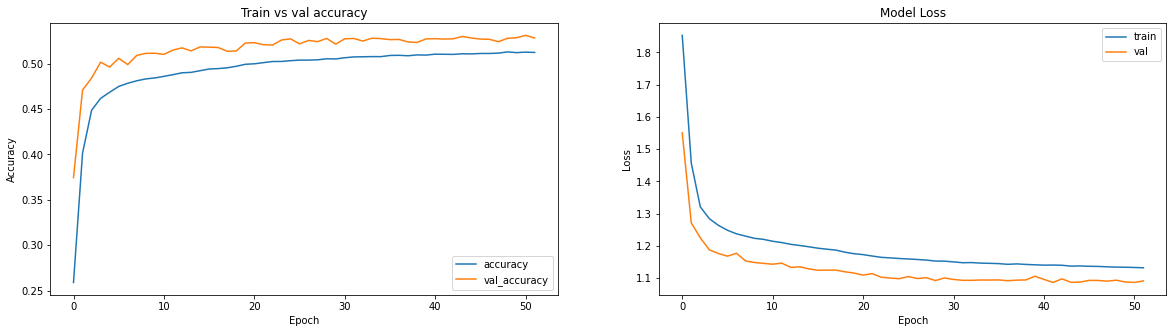

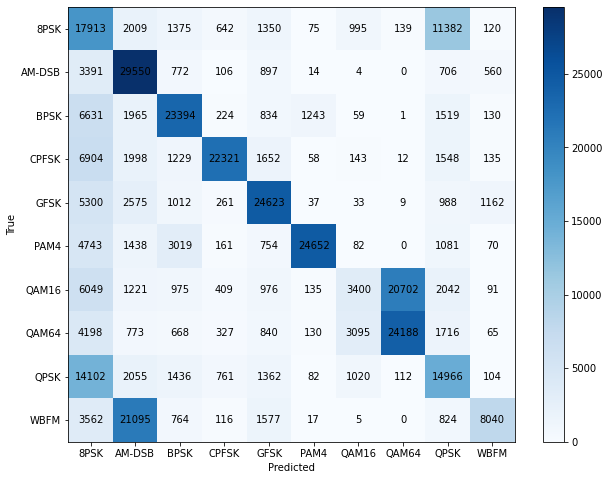

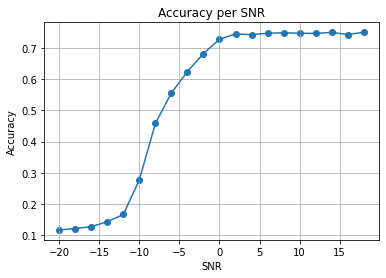

11250/11250 [==============================] - 85s 8ms/step - loss: 1.0767 - accuracy: 0.5362


In [57]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001, model_001_history)

In [100]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.12,0.12,0.13,0.14,0.17,0.28,0.46,0.56,0.62,0.68,0.73,0.74,0.74,0.75,0.75,0.75,0.75,0.75,0.74,0.75


In [101]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.5121654272079468
Max Val accuracy =  0.5280476212501526
Max Test accuracy =  0.5362416505813599
Average Accuracy =  0.5365
Accuracy at SNR=0dB =  0.73


##### LR = 0.0001

In [102]:
model_0001, model_0001_history = load_model("CNN_RAW_0.0001")

11250/11250 [==============================] - 88s 8ms/step


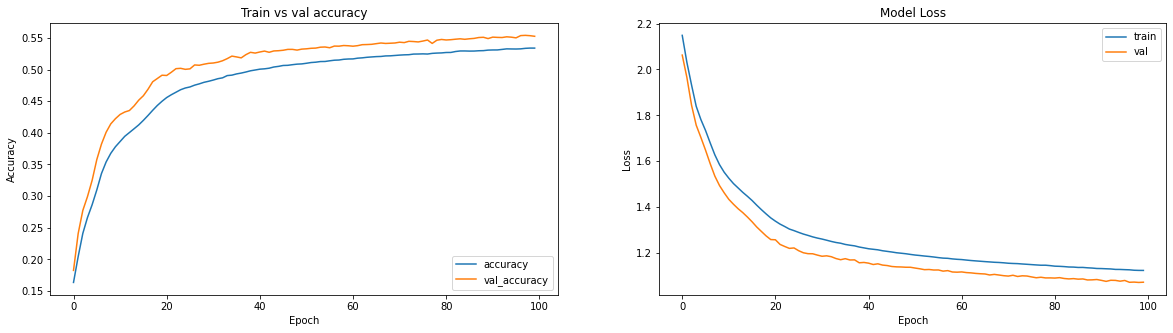

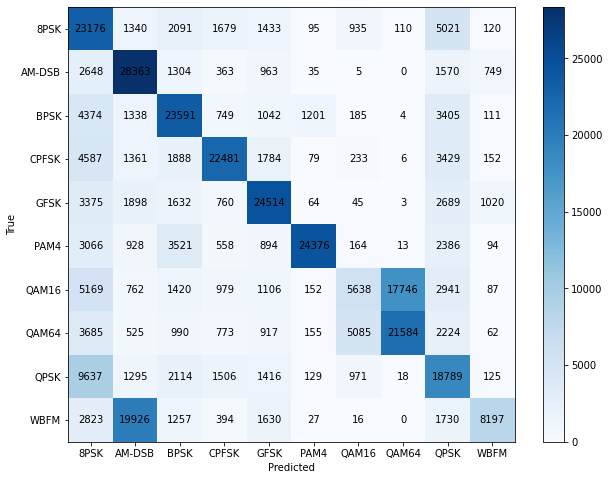

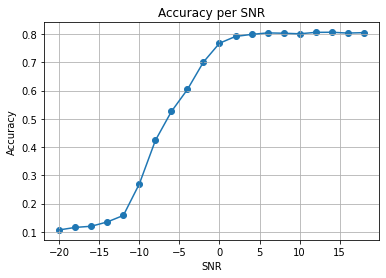

11250/11250 [==============================] - 98s 9ms/step - loss: 1.0643 - accuracy: 0.5575


In [103]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_0001, model_0001_history)

In [104]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.12,0.12,0.13,0.16,0.27,0.42,0.53,0.6,0.7,0.77,0.79,0.8,0.8,0.8,0.8,0.81,0.81,0.8,0.81


In [105]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.5338809490203857
Max Val accuracy =  0.5525714159011841
Max Test accuracy =  0.5575249791145325
Average Accuracy =  0.5575000000000001
Accuracy at SNR=0dB =  0.77


##### LR = 0.00001

In [106]:
model_00001, model_00001_history = load_model("CNN_RAW_0.00001")

11250/11250 [==============================] - 93s 8ms/step


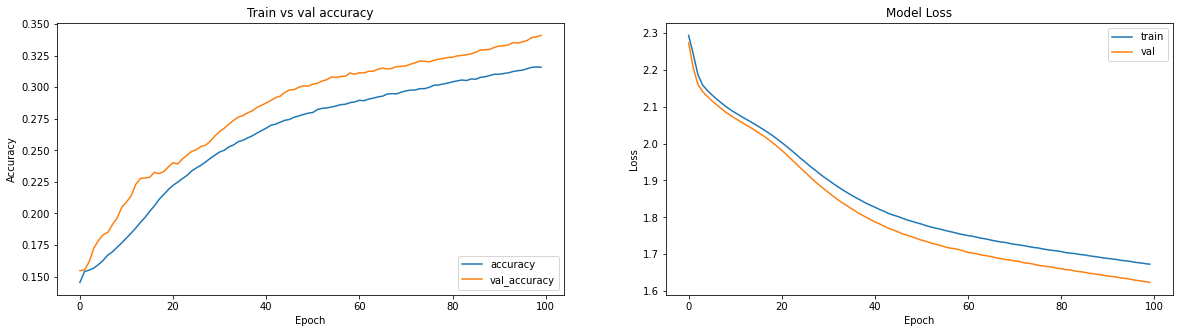

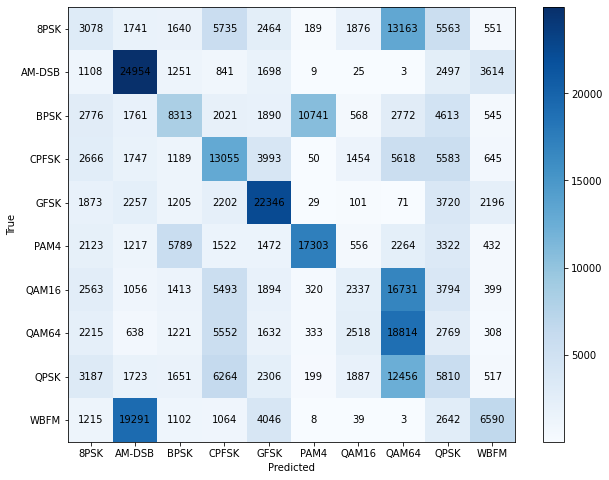

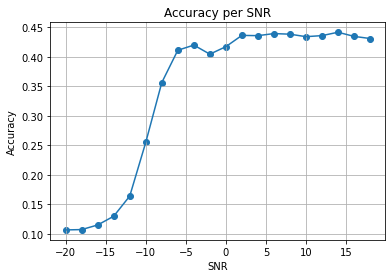

11250/11250 [==============================] - 76s 7ms/step - loss: 1.6216 - accuracy: 0.3406


In [107]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_00001, model_00001_history)

In [108]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.11,0.12,0.13,0.16,0.25,0.36,0.41,0.42,0.4,0.42,0.44,0.44,0.44,0.44,0.43,0.44,0.44,0.43,0.43


In [109]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.31583958864212036
Max Val accuracy =  0.3410952389240265
Max Test accuracy =  0.3405555486679077
Average Accuracy =  0.341
Accuracy at SNR=0dB =  0.42


##### LR = 0.001 + Decay

In [110]:
model_001_decay, model_001_decay_history = load_model("CNN_RAW_0.001+DECAY*10-6")

11250/11250 [==============================] - 90s 8ms/step


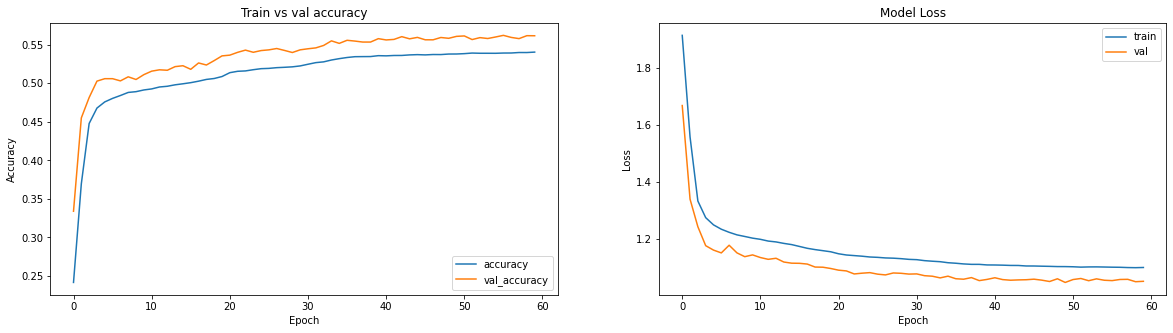

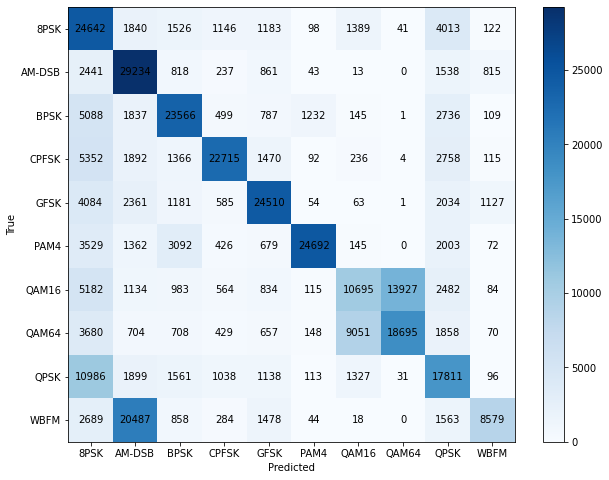

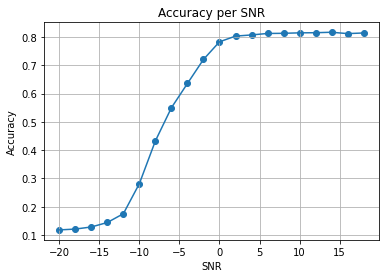

11250/11250 [==============================] - 83s 7ms/step - loss: 1.0332 - accuracy: 0.5698


In [111]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001_decay, model_001_decay_history)

In [112]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.12,0.12,0.13,0.14,0.18,0.28,0.43,0.55,0.64,0.72,0.78,0.8,0.81,0.81,0.81,0.81,0.81,0.82,0.81,0.81


In [113]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.5404223203659058
Max Val accuracy =  0.5616428852081299
Max Test accuracy =  0.5698305368423462
Average Accuracy =  0.5690000000000001
Accuracy at SNR=0dB =  0.78


#### INTEGRAL

##### LR = 0.001

In [151]:
model_INT_001, model_INT_001_history = load_model("CNN_INT_0.001")

11250/11250 [==============================] - 72s 6ms/step


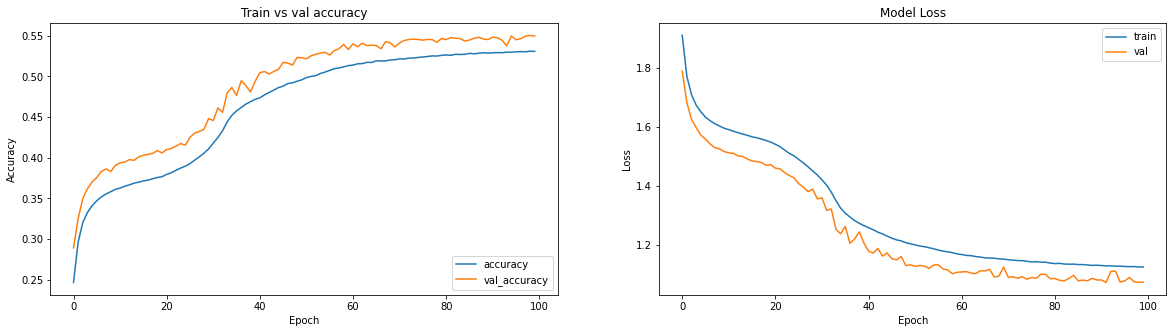

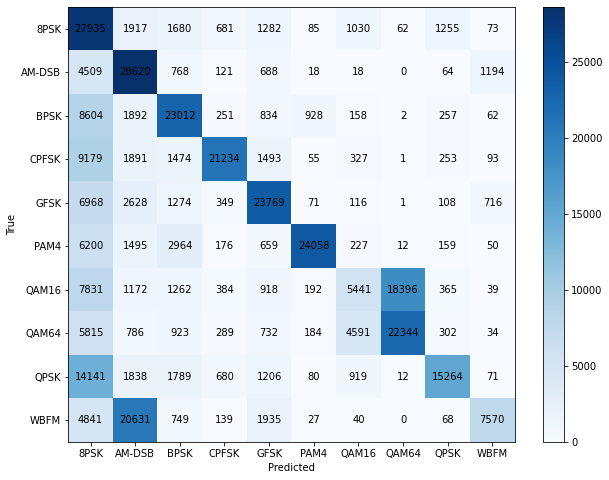

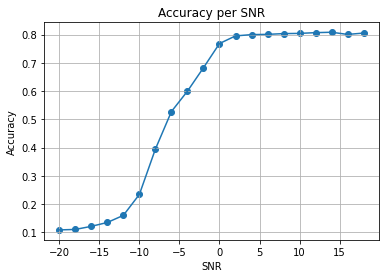

11250/11250 [==============================] - 78s 7ms/step - loss: 1.0657 - accuracy: 0.5535


In [152]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_INT_001, model_INT_001_history)

In [153]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.11,0.12,0.14,0.16,0.23,0.39,0.53,0.6,0.68,0.77,0.8,0.8,0.8,0.8,0.8,0.81,0.81,0.8,0.81


In [154]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.5306992530822754
Max Val accuracy =  0.5494047403335571
Max Test accuracy =  0.553463876247406
Average Accuracy =  0.5535000000000001
Accuracy at SNR=0dB =  0.77


##### LR = 0.0001

In [155]:
model_001_INT, model_0001_INT_history = load_model("CNN_INT_0.0001")

11250/11250 [==============================] - 73s 6ms/step


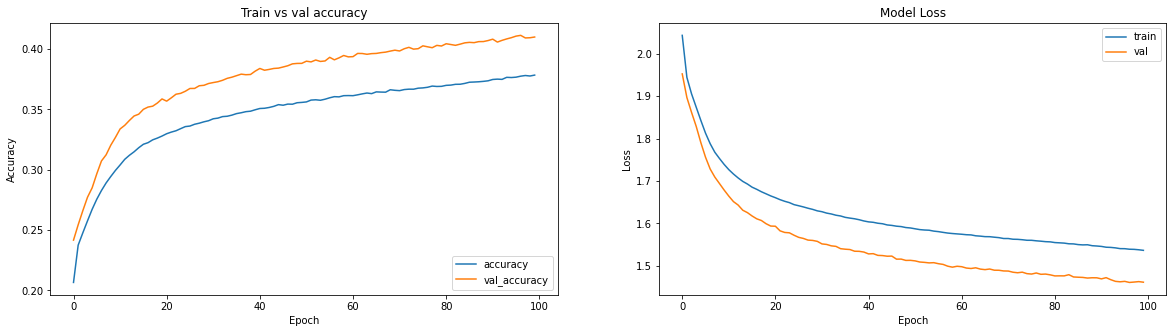

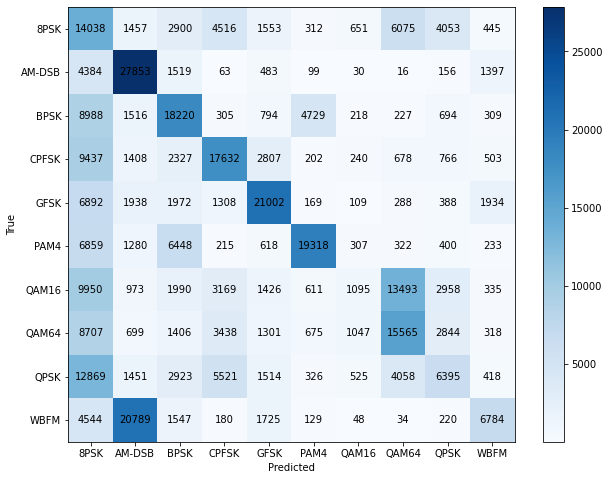

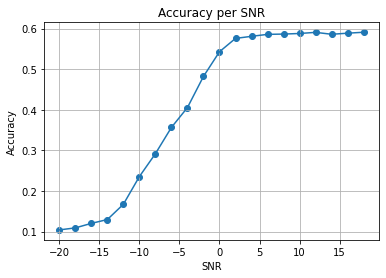

11250/11250 [==============================] - 77s 7ms/step - loss: 1.4578 - accuracy: 0.4108


In [156]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001_INT, model_0001_INT_history)

In [157]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.1,0.11,0.12,0.13,0.17,0.24,0.29,0.36,0.41,0.48,0.54,0.58,0.58,0.59,0.59,0.59,0.59,0.59,0.59,0.59


In [158]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.3783947229385376
Max Val accuracy =  0.4099523723125458
Max Test accuracy =  0.41083890199661255
Average Accuracy =  0.41200000000000003
Accuracy at SNR=0dB =  0.54


##### LR = 0.001 + Decay

In [159]:
model_001_INT_decay, model_001_INT_decay_history = load_model("CNN_INT_0.001+DECAY*10-6")

11250/11250 [==============================] - 71s 6ms/step


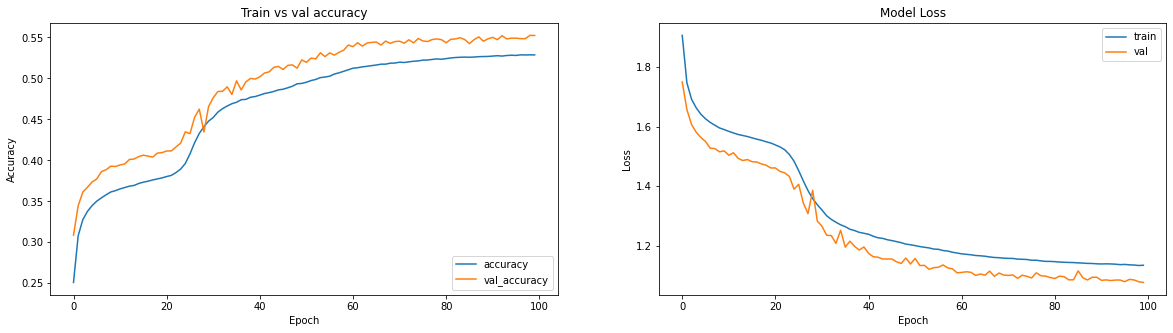

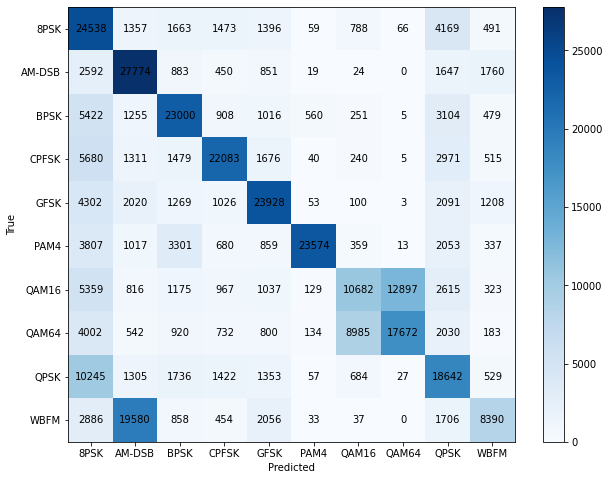

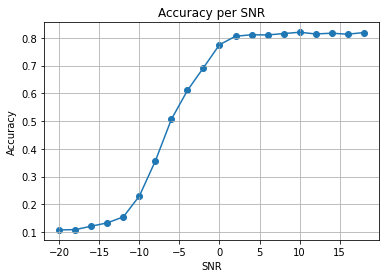

11250/11250 [==============================] - 77s 7ms/step - loss: 1.0656 - accuracy: 0.5563


In [160]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001_INT_decay, model_001_INT_decay_history)

In [161]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.11,0.12,0.13,0.16,0.23,0.36,0.51,0.61,0.69,0.78,0.81,0.81,0.81,0.82,0.82,0.81,0.82,0.81,0.82


In [162]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.5286390781402588
Max Val accuracy =  0.5523571372032166
Max Test accuracy =  0.5563416481018066
Average Accuracy =  0.557
Accuracy at SNR=0dB =  0.78


## Vanilla RNN Model

### Model

In [ ]:
opt = Adam(lr=0.001)

RNNModel = Sequential()
RNNModel.add(SimpleRNN(128, input_shape=list(x_train.shape[1:]), activation='relu'))
RNNModel.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
RNNModel.add(Dropout(0.3))  # add dropout layer with rate 0.2
RNNModel.add(Dense(64, activation='relu'))
RNNModel.add(Dense(units=10, activation='softmax'))
RNNModel.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
RNNModel.summary()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 58,314
Trainable params: 58,314
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_rnn = RNNModel.fit(x_train, y_train[:,0], 
                           epochs=100, 
                           batch_size=1024, 
                           validation_data=(x_val, y_val[:,0]),
                           verbose=1, 
                           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])


Epoch 1/100
780/780 [==============================] - 8s 6ms/step - loss: 1.7766 - accuracy: 0.2831 - val_loss: 1.5942 - val_accuracy: 0.3356
Epoch 2/100
780/780 [==============================] - 4s 5ms/step - loss: 1.5643 - accuracy: 0.3411 - val_loss: 1.5143 - val_accuracy: 0.3545
Epoch 3/100
780/780 [==============================] - 4s 6ms/step - loss: 1.5087 - accuracy: 0.3588 - val_loss: 1.4735 - val_accuracy: 0.3710
Epoch 4/100
780/780 [==============================] - 5s 6ms/step - loss: 1.4742 - accuracy: 0.3730 - val_loss: 1.4368 - val_accuracy: 0.3879
Epoch 5/100
780/780 [==============================] - 4s 6ms/step - loss: 1.4408 - accuracy: 0.3899 - val_loss: 1.4133 - val_accuracy: 0.4042
Epoch 6/100
780/780 [==============================] - 5s 7ms/step - loss: 1.4114 - accuracy: 0.4034 - val_loss: 1.3824 - val_accuracy: 0.4126
Epoch 7/100
780/780 [==============================] - 4s 6ms/step - loss: 1.3904 - accuracy: 0.4129 - val_loss: 1.3650 - val_accuracy: 0.4235

In [ ]:
save_model(RNNModel, history_rnn, "RNN_INT_0.001")

#### Tests

In [ ]:
history_rnn = RNNModel.fit(x_train, y_train[:,0], 
                           epochs=100, 
                           batch_size=1024, 
                           validation_data=(x_val, y_val[:,0]),
                           verbose=1, 
                           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])


Epoch 1/100
780/780 [==============================] - 6s 7ms/step - loss: 1.7918 - accuracy: 0.2818 - val_loss: 1.5718 - val_accuracy: 0.3549
Epoch 2/100
780/780 [==============================] - 5s 7ms/step - loss: 1.5463 - accuracy: 0.3634 - val_loss: 1.4907 - val_accuracy: 0.3820
Epoch 3/100
780/780 [==============================] - 6s 7ms/step - loss: 1.4895 - accuracy: 0.3838 - val_loss: 1.4589 - val_accuracy: 0.3909
Epoch 4/100
780/780 [==============================] - 7s 9ms/step - loss: 1.4549 - accuracy: 0.3950 - val_loss: 1.4214 - val_accuracy: 0.4070
Epoch 5/100
780/780 [==============================] - 5s 6ms/step - loss: 1.4266 - accuracy: 0.4049 - val_loss: 1.4095 - val_accuracy: 0.4137
Epoch 6/100
780/780 [==============================] - 4s 6ms/step - loss: 1.4030 - accuracy: 0.4117 - val_loss: 1.3734 - val_accuracy: 0.4210
Epoch 7/100
780/780 [==============================] - 5s 7ms/step - loss: 1.3778 - accuracy: 0.4198 - val_loss: 1.3539 - val_accuracy: 0.4277

### Evaluation

#### RAW

##### LR = 0.001

In [126]:
model_001, model_001_history = load_model("RNN_RAW_0.001")

11250/11250 [==============================] - 20s 2ms/step


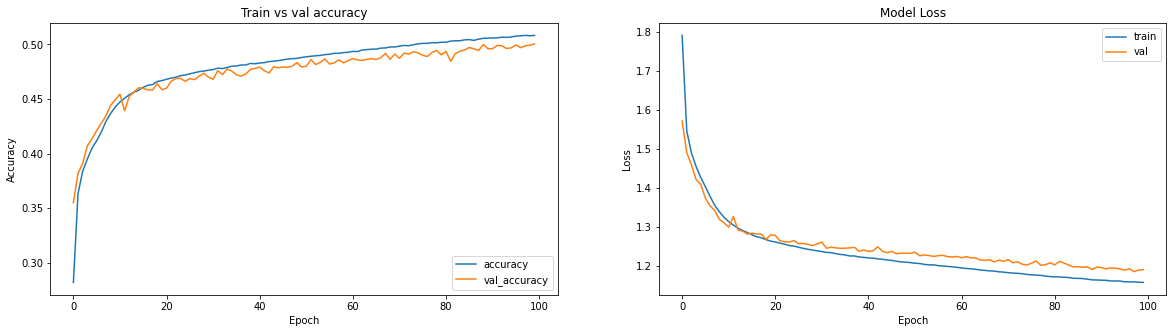

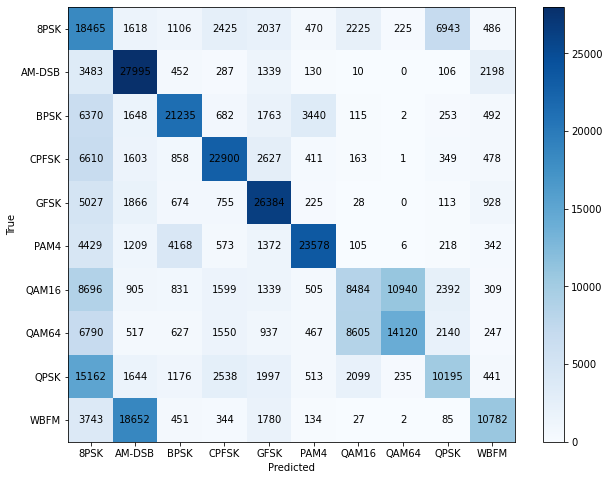

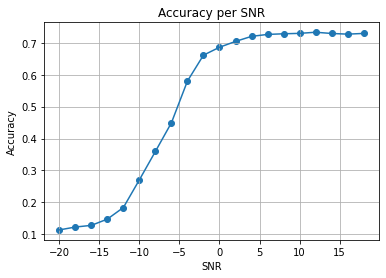

11250/11250 [==============================] - 23s 2ms/step - loss: 1.1504 - accuracy: 0.5115


In [127]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001, model_001_history)

In [128]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.12,0.13,0.15,0.18,0.27,0.36,0.45,0.58,0.66,0.69,0.7,0.72,0.73,0.73,0.73,0.73,0.73,0.73,0.73


In [129]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.508385956287384
Max Val accuracy =  0.5005714297294617
Max Test accuracy =  0.5114944577217102
Average Accuracy =  0.5115000000000001
Accuracy at SNR=0dB =  0.69


##### LR = 0.0001

In [130]:
model_0001, model_0001_history = load_model("RNN_RAW_0.0001")

11250/11250 [==============================] - 20s 2ms/step


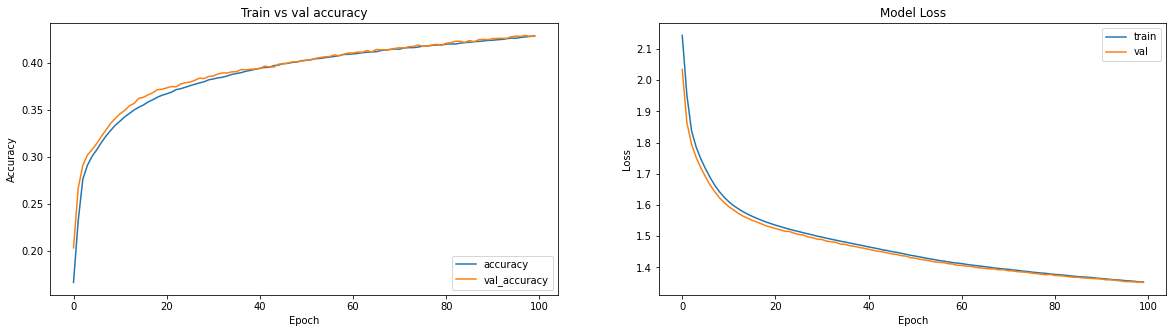

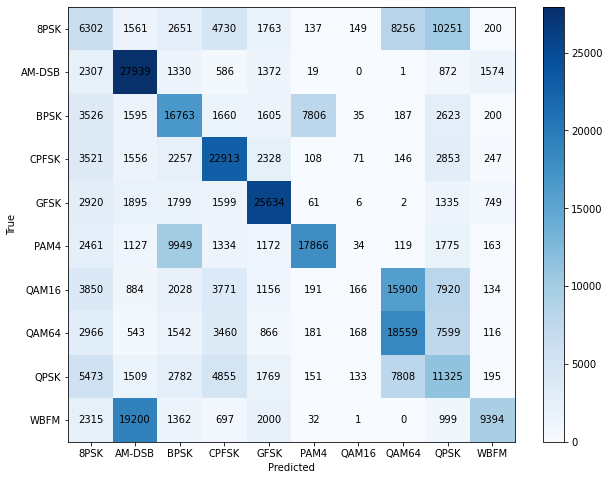

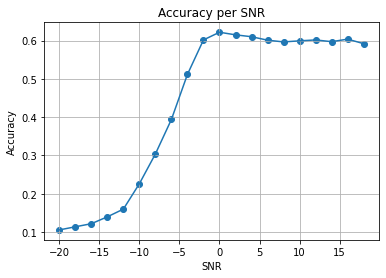

11250/11250 [==============================] - 23s 2ms/step - loss: 1.3363 - accuracy: 0.4357


In [131]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_0001, model_0001_history)

In [132]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.11,0.12,0.14,0.16,0.23,0.3,0.39,0.51,0.6,0.62,0.61,0.61,0.6,0.6,0.6,0.6,0.6,0.6,0.59


In [133]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.4288797080516815
Max Val accuracy =  0.4292857050895691
Max Test accuracy =  0.43572500348091125
Average Accuracy =  0.43499999999999994
Accuracy at SNR=0dB =  0.62


##### LR = 0.001 + Decay

In [134]:
model_001_decay, model_001_decay_history = load_model("RNN_RAW_0.001+DECAY*10-6")

11250/11250 [==============================] - 20s 2ms/step


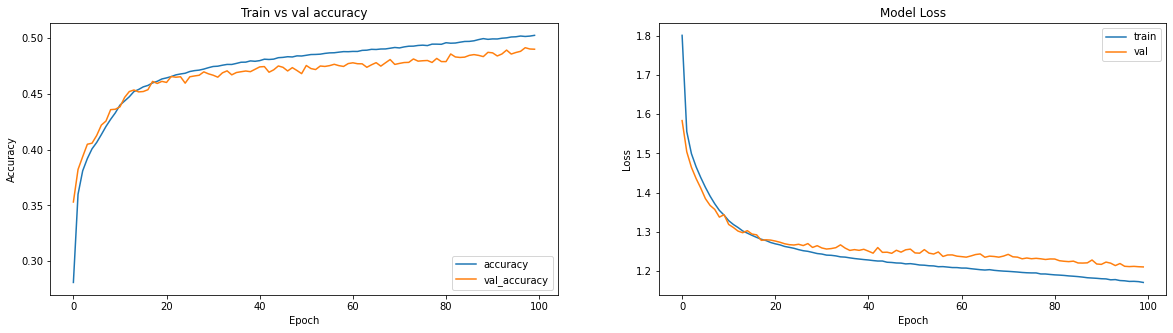

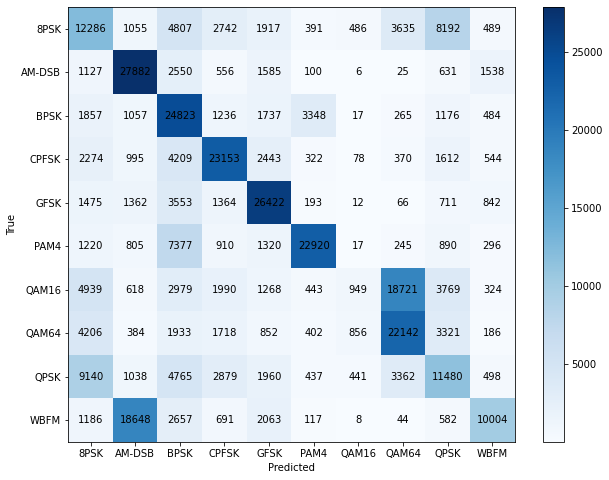

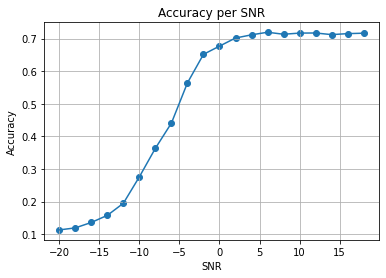

11250/11250 [==============================] - 25s 2ms/step - loss: 1.1671 - accuracy: 0.5057


In [135]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001_decay, model_001_decay_history)

In [136]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.12,0.14,0.16,0.19,0.28,0.36,0.44,0.56,0.65,0.68,0.7,0.71,0.72,0.71,0.72,0.72,0.71,0.71,0.72


In [137]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.5023972392082214
Max Val accuracy =  0.4899761974811554
Max Test accuracy =  0.5057250261306763
Average Accuracy =  0.5055000000000001
Accuracy at SNR=0dB =  0.68


#### INTEGRAL

##### LR = 0.001

In [ ]:
model_INT_001, model_INT_001_history = load_model("RNN_INT_0.001")

11250/11250 [==============================] - 19s 2ms/step


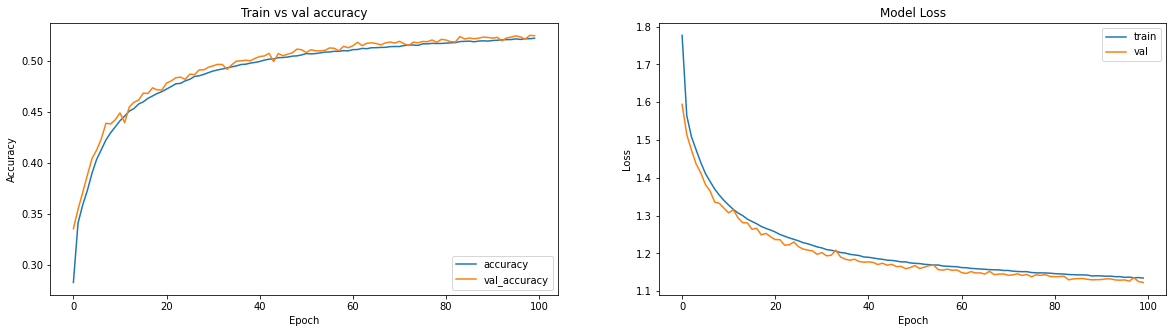

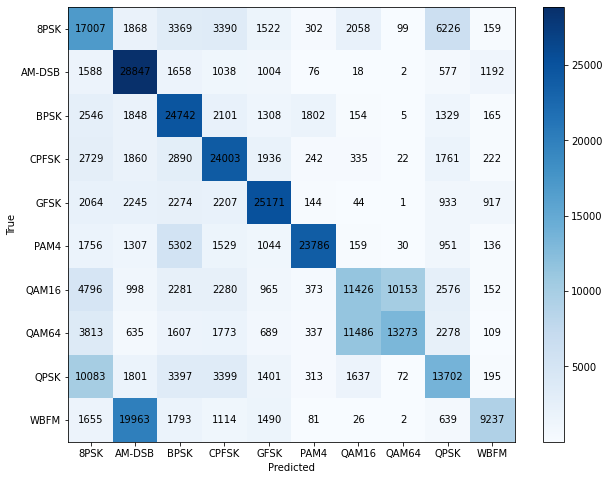

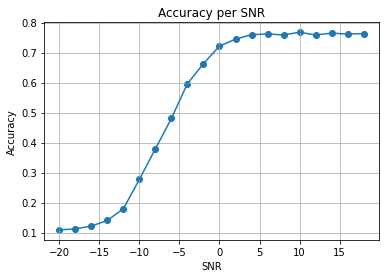

11250/11250 [==============================] - 26s 2ms/step - loss: 1.1093 - accuracy: 0.5311


In [ ]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_INT_001, model_INT_001_history)

In [ ]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.11,0.12,0.14,0.18,0.28,0.38,0.48,0.6,0.66,0.72,0.74,0.76,0.76,0.76,0.77,0.76,0.76,0.76,0.76


In [ ]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.5217919945716858
Max Val accuracy =  0.524238109588623
Max Test accuracy =  0.5310944318771362
Average Accuracy =  0.5305
Accuracy at SNR=0dB =  0.72


##### LR = 0.0001

In [ ]:
model_001_INT, model_0001_INT_history = load_model("RNN_INT_0.0001")

11250/11250 [==============================] - 21s 2ms/step


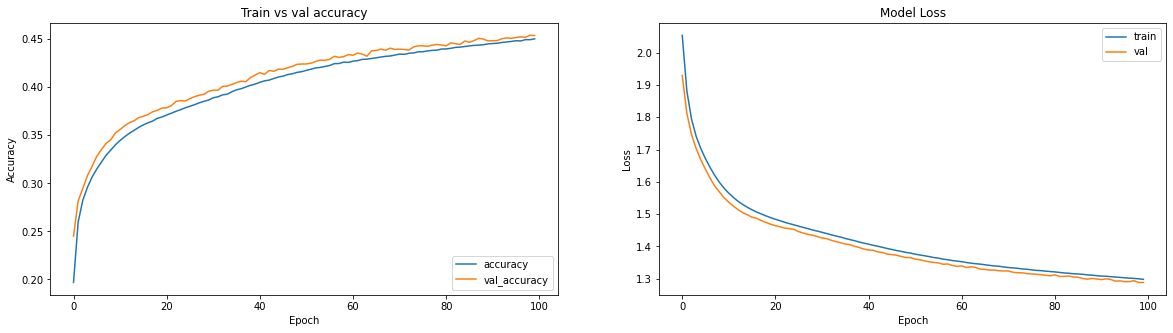

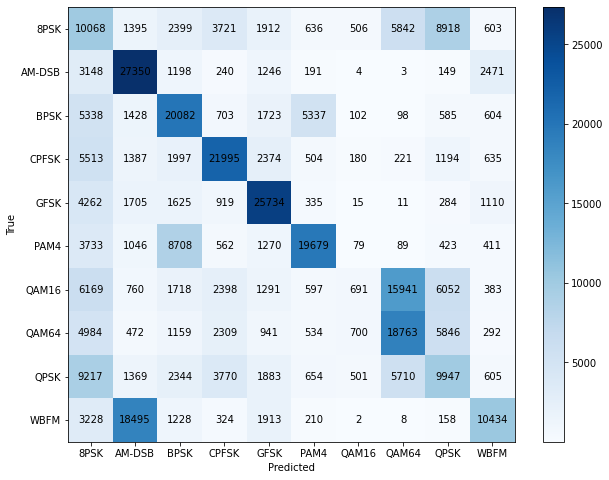

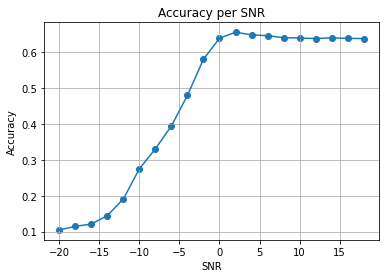

11250/11250 [==============================] - 25s 2ms/step - loss: 1.2798 - accuracy: 0.4576


In [ ]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001_INT, model_0001_INT_history)

In [ ]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.1,0.11,0.12,0.14,0.19,0.27,0.33,0.39,0.48,0.58,0.64,0.66,0.65,0.65,0.64,0.64,0.64,0.64,0.64,0.64


In [ ]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.45038846135139465
Max Val accuracy =  0.453809529542923
Max Test accuracy =  0.45761945843696594
Average Accuracy =  0.4575
Accuracy at SNR=0dB =  0.64


##### LR = 0.001 + Decay

In [ ]:
model_001_INT_decay, model_001_INT_decay_history = load_model("RNN_INT_0.001+DECAY*10-6")

11250/11250 [==============================] - 19s 2ms/step


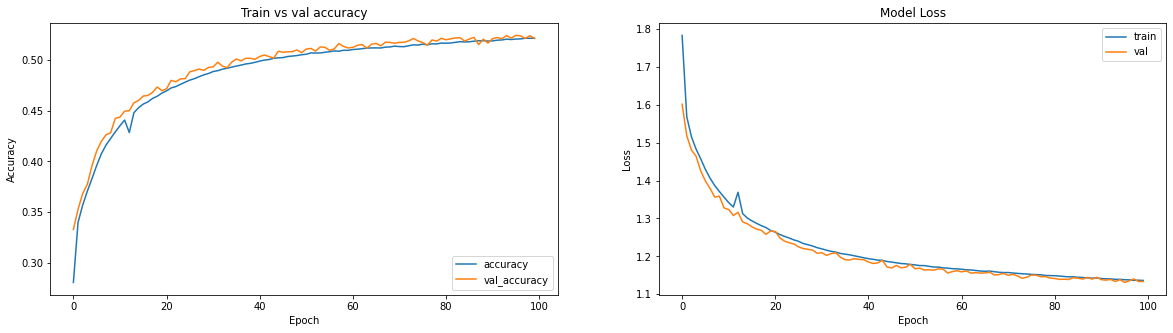

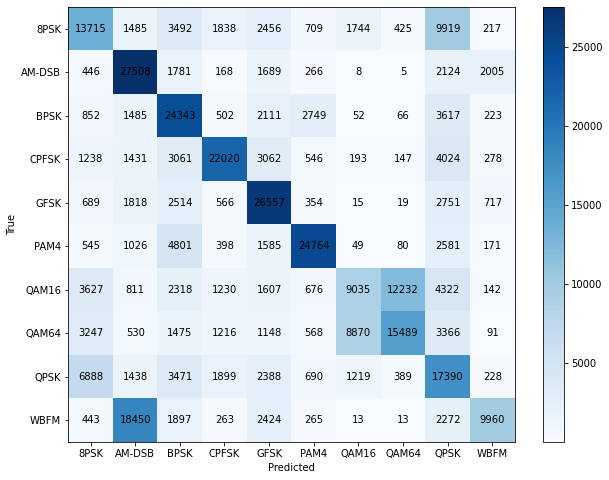

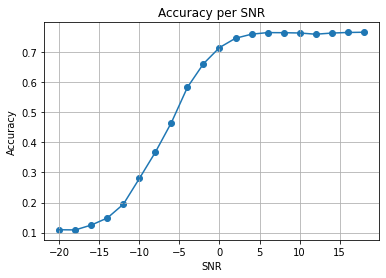

11250/11250 [==============================] - 26s 2ms/step - loss: 1.1148 - accuracy: 0.5299


In [ ]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001_INT_decay, model_001_INT_decay_history)

In [ ]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.11,0.13,0.15,0.19,0.28,0.37,0.47,0.58,0.66,0.71,0.74,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76


In [ ]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.5213608741760254
Max Val accuracy =  0.5210475921630859
Max Test accuracy =  0.5299472212791443
Average Accuracy =  0.5289999999999999
Accuracy at SNR=0dB =  0.71


## LSTM Model

### Model

In [ ]:
opt = Adam(lr=0.001)
# , decay=1e-6

LSTMModel = Sequential()
LSTMModel.add(LSTM(128, dropout = 0.3, return_sequences = True, recurrent_dropout = 0.3, input_shape = list(x_train.shape[1:])))
LSTMModel.add(Flatten())
LSTMModel.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
LSTMModel.add(Dense(10, activation = 'softmax'))
LSTMModel.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
LSTMModel.summary()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 128)            131584    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 165,770
Trainable params: 165,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = LSTMModel.fit(x_train, y_train[:,0], 
                                 epochs=100, batch_size=1024, 
                                 validation_data=(x_val, y_val[:,0]),
                                 verbose=1, 
                                 callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])


Epoch 1/100
780/780 [==============================] - 22s 25ms/step - loss: 1.9396 - accuracy: 0.2436 - val_loss: 1.8385 - val_accuracy: 0.2793
Epoch 2/100
780/780 [==============================] - 10s 13ms/step - loss: 1.8069 - accuracy: 0.2821 - val_loss: 1.7459 - val_accuracy: 0.2943
Epoch 3/100
780/780 [==============================] - 10s 12ms/step - loss: 1.7328 - accuracy: 0.3022 - val_loss: 1.6786 - val_accuracy: 0.3155
Epoch 4/100
780/780 [==============================] - 10s 12ms/step - loss: 1.6864 - accuracy: 0.3153 - val_loss: 1.6356 - val_accuracy: 0.3326
Epoch 5/100
780/780 [==============================] - 10s 13ms/step - loss: 1.6506 - accuracy: 0.3272 - val_loss: 1.5995 - val_accuracy: 0.3472
Epoch 6/100
780/780 [==============================] - 10s 12ms/step - loss: 1.6236 - accuracy: 0.3365 - val_loss: 1.5727 - val_accuracy: 0.3520
Epoch 7/100
780/780 [==============================] - 10s 12ms/step - loss: 1.6033 - accuracy: 0.3428 - val_loss: 1.5562 - val_ac

In [ ]:
save_model(LSTMModel, history_lstm, "LSTM_INT_0.001")

### Evaluation

#### RAW

##### LR = 0.001

In [138]:
model_001, model_001_history = load_model("LSTM_RAW_0.001")

11250/11250 [==============================] - 28s 2ms/step


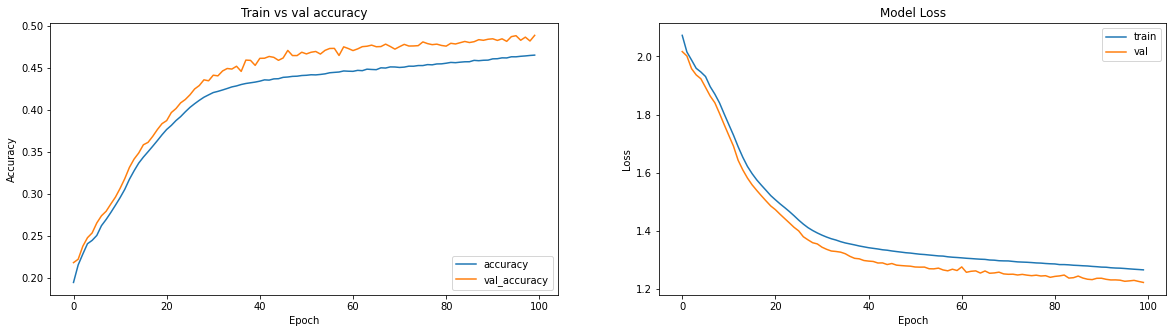

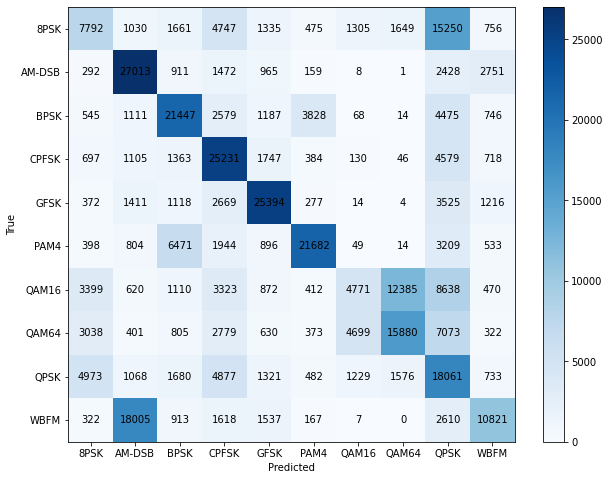

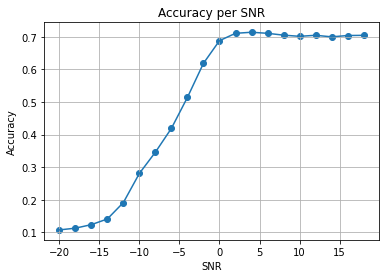

11250/11250 [==============================] - 31s 3ms/step - loss: 1.2132 - accuracy: 0.4947


In [139]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001, model_001_history)

In [140]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.11,0.12,0.14,0.19,0.28,0.35,0.42,0.51,0.62,0.69,0.71,0.71,0.71,0.7,0.7,0.7,0.7,0.7,0.7


In [141]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.4651077687740326
Max Val accuracy =  0.4886428713798523
Max Test accuracy =  0.49470001459121704
Average Accuracy =  0.4934999999999999
Accuracy at SNR=0dB =  0.69


##### LR = 0.0001

In [142]:
model_0001, model_0001_history = load_model("LSTM_RAW_0.0001")

11250/11250 [==============================] - 28s 2ms/step


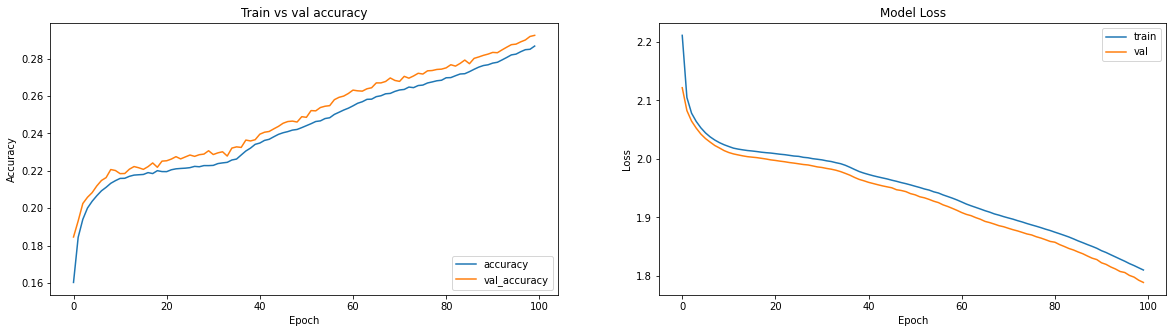

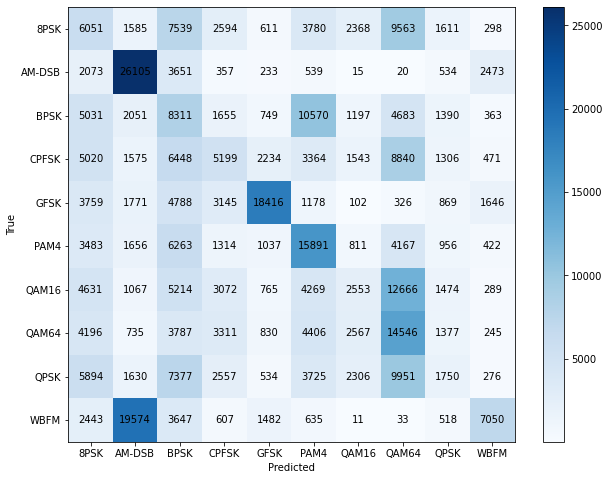

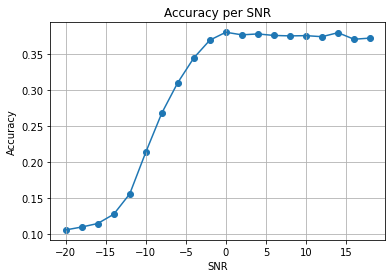

11250/11250 [==============================] - 31s 3ms/step - loss: 1.7920 - accuracy: 0.2941


In [143]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_0001, model_0001_history)

In [144]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.11,0.12,0.13,0.16,0.21,0.27,0.31,0.34,0.37,0.38,0.38,0.38,0.38,0.38,0.38,0.37,0.38,0.37,0.37


In [145]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.2866804599761963
Max Val accuracy =  0.29240477085113525
Max Test accuracy =  0.2940889000892639
Average Accuracy =  0.29500000000000004
Accuracy at SNR=0dB =  0.38


##### LR = 0.001 + Decay

In [146]:
model_001_decay, model_001_decay_history = load_model("LSTM_RAW_0.001+DECAY*10-6")

11250/11250 [==============================] - 29s 3ms/step


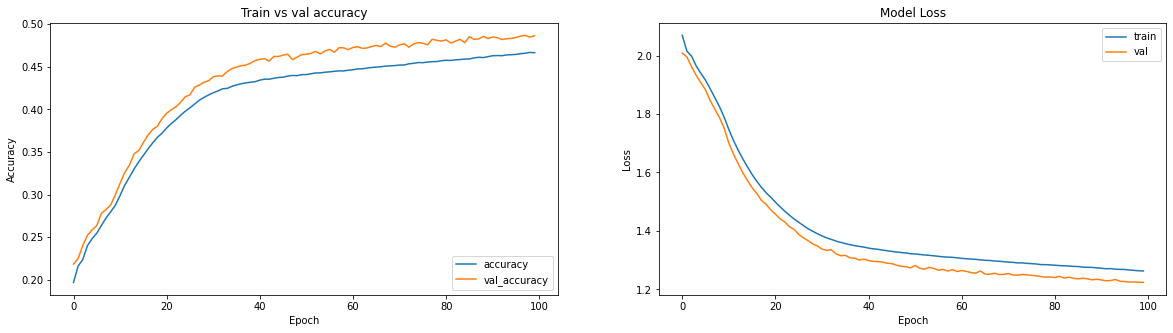

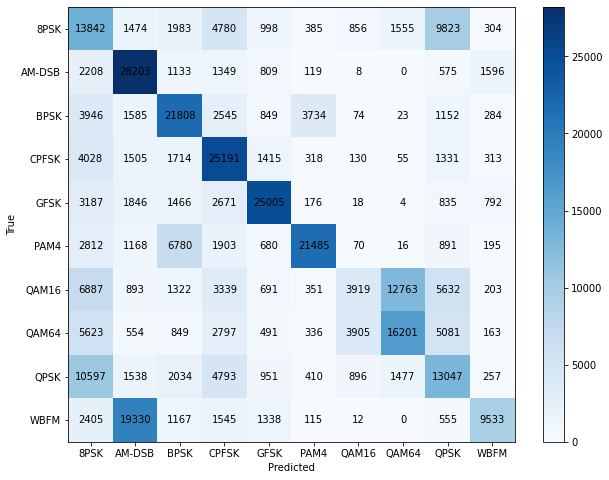

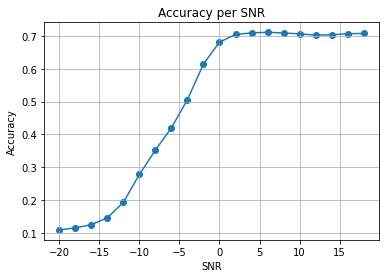

11250/11250 [==============================] - 32s 3ms/step - loss: 1.2114 - accuracy: 0.4951


In [147]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001_decay, model_001_decay_history)

In [148]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.12,0.13,0.15,0.19,0.28,0.35,0.42,0.51,0.61,0.68,0.7,0.71,0.71,0.71,0.71,0.7,0.7,0.71,0.71


In [149]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.46655890345573425
Max Val accuracy =  0.4865952432155609
Max Test accuracy =  0.4950944483280182
Average Accuracy =  0.4955
Accuracy at SNR=0dB =  0.68


#### INTEGRAL

##### LR = 0.001

In [ ]:
model_INT_001, model_INT_001_history = load_model("LSTM_INT_0.001")

11250/11250 [==============================] - 27s 2ms/step


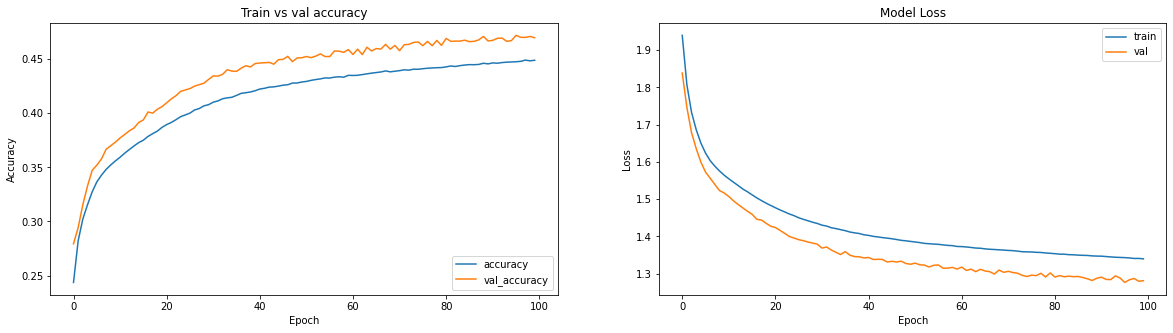

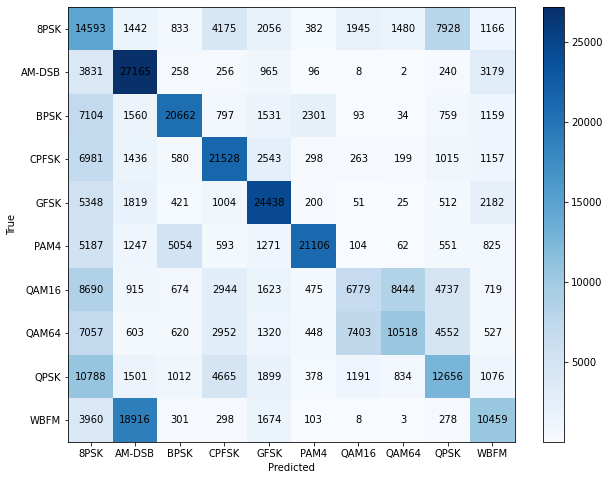

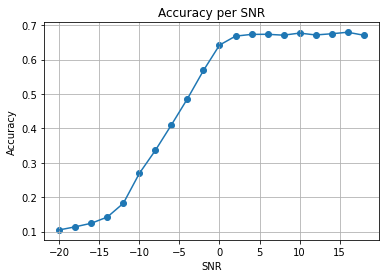

11250/11250 [==============================] - 30s 3ms/step - loss: 1.2769 - accuracy: 0.4720


In [ ]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_INT_001, model_INT_001_history)

In [ ]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.1,0.11,0.12,0.14,0.18,0.27,0.34,0.41,0.49,0.57,0.64,0.67,0.67,0.67,0.67,0.68,0.67,0.67,0.68,0.67


In [ ]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.4490087628364563
Max Val accuracy =  0.46988093852996826
Max Test accuracy =  0.4719555675983429
Average Accuracy =  0.471
Accuracy at SNR=0dB =  0.64


##### LR = 0.0001

In [ ]:
model_001_INT, model_0001_INT_history = load_model("LSTM_INT_0.0001")

11250/11250 [==============================] - 25s 2ms/step


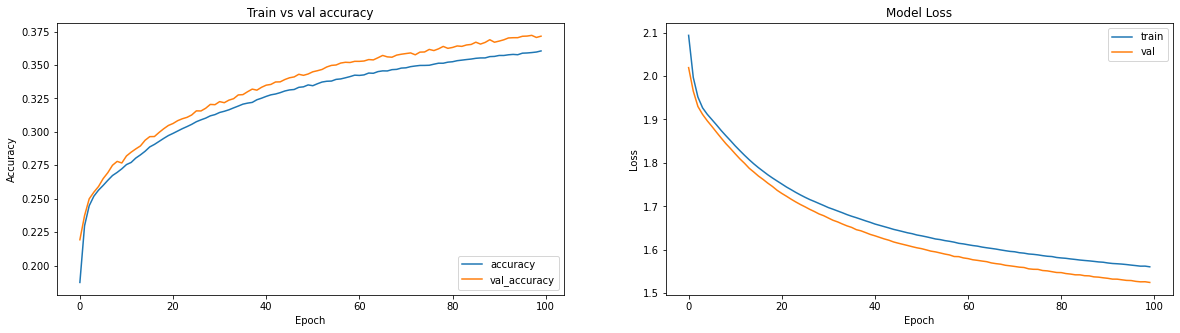

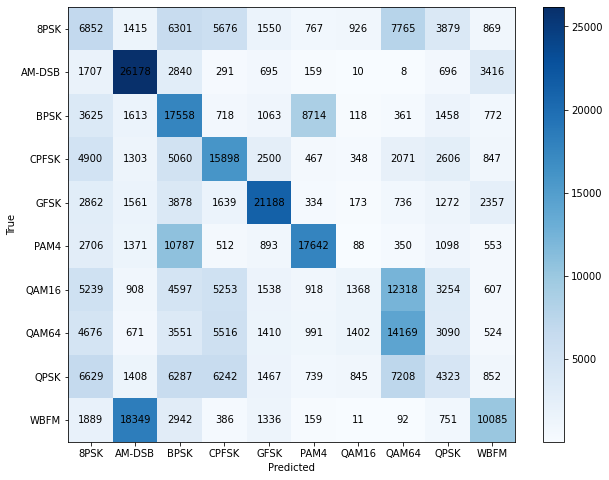

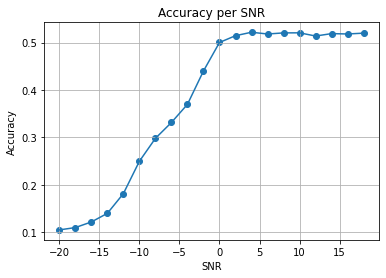

11250/11250 [==============================] - 30s 3ms/step - loss: 1.5185 - accuracy: 0.3757


In [ ]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001_INT, model_0001_INT_history)

In [ ]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.11,0.12,0.14,0.18,0.25,0.3,0.33,0.37,0.44,0.5,0.51,0.52,0.52,0.52,0.52,0.51,0.52,0.52,0.52


In [ ]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.36053383350372314
Max Val accuracy =  0.37157142162323
Max Test accuracy =  0.37572500109672546
Average Accuracy =  0.3754999999999999
Accuracy at SNR=0dB =  0.5


##### LR = 0.001 + Decay

In [ ]:
model_001_INT_decay, model_001_INT_decay_history = load_model("LSTM_INT_0.001+DECAY*10-6")

11250/11250 [==============================] - 23s 2ms/step


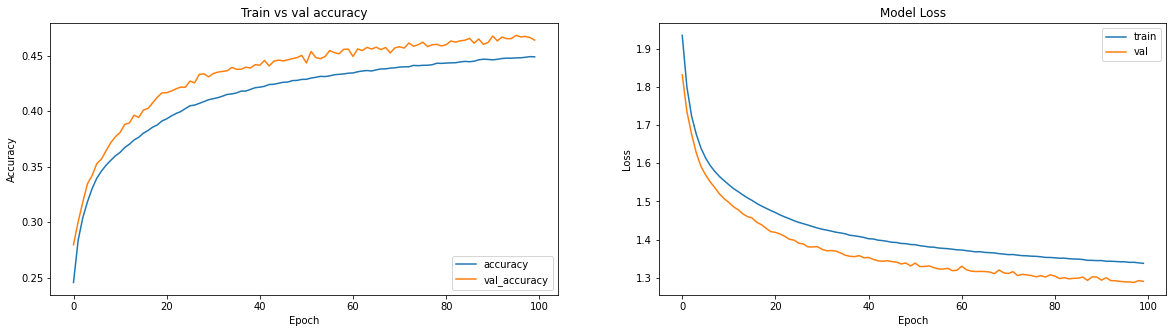

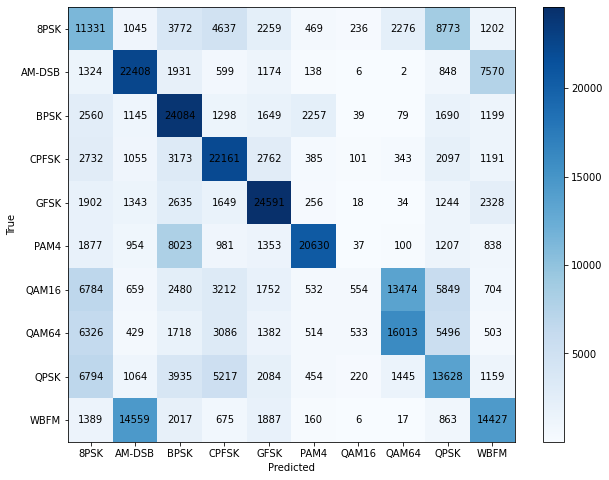

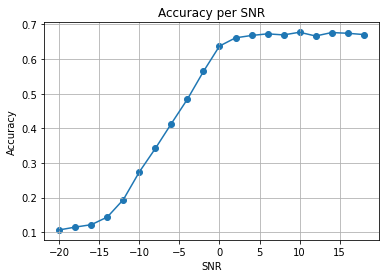

11250/11250 [==============================] - 30s 3ms/step - loss: 1.2776 - accuracy: 0.4717


In [ ]:
test_acc, train_acc, val_acc, snr_acc = evaluate_model(model_001_INT_decay, model_001_INT_decay_history)

In [ ]:
snr_acc

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
acc,0.11,0.12,0.12,0.14,0.19,0.27,0.34,0.41,0.48,0.56,0.64,0.66,0.67,0.67,0.67,0.68,0.67,0.68,0.67,0.67


In [ ]:
print_accuracies(test_acc, train_acc, val_acc, snr_acc)

Max Train accuracy =  0.44885966181755066
Max Val accuracy =  0.4638809561729431
Max Test accuracy =  0.4717416763305664
Average Accuracy =  0.471
Accuracy at SNR=0dB =  0.64
